In [9]:
import pandas as pd
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor
import torch
import cv2
import os
import glob
from pathlib import Path

In [20]:
MODEL_NAME = "nlpconnect/vit-gpt2-image-captioning"
input_dir = Path().resolve() / 'IMAGE_INPUT_PATH'
output_dir = Path().resolve()/ 'IMAGE_OUTPUT_PATH'

In [17]:
print(input_dir)

/vsc-hard-mounts/leuven-data/351/vsc35146/IMAGE_INPUT_PATH


Analyzing image /vsc-hard-mounts/leuven-data/351/vsc35146/IMAGE_INPUT_PATH/GOPR0647.JPG


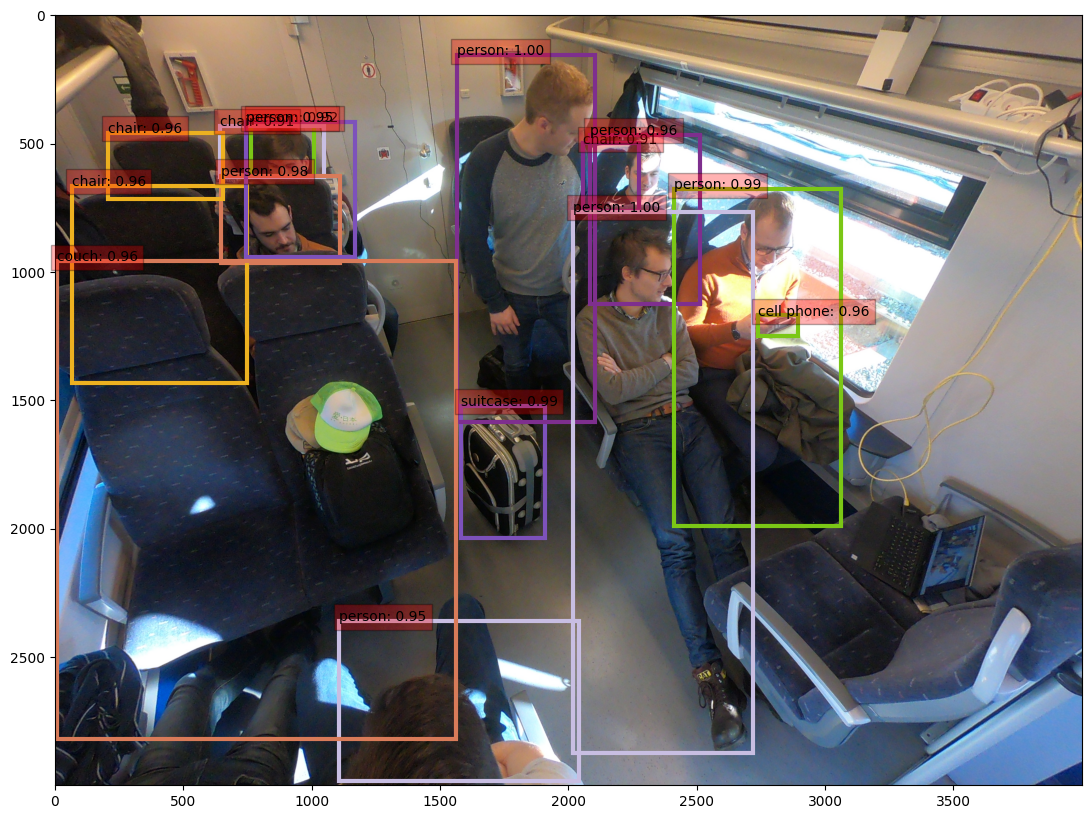

In [18]:
# Load DETR model
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Loop through input images
for image_path in glob.glob(os.path.join(input_dir, "*.JPG")):
    
    print(f"Analyzing image {image_path}")
    
    # Load image
    image = Image.open(image_path)

    # Extract image features
    inputs = feature_extractor(image, return_tensors="pt")
    inputs.keys()
    
    outputs = model(**inputs)
    
    col = [[0.494, 0.184, 0.556], [0.484, 0.779, 0.088], [0.784, 0.745, 0.888],
              [0.492, 0.323, 0.732], [0.849, 0.484, 0.348], [0.929, 0.694, 0.125]]

    # keep bounding boxes with a 0.90 threshold
    probability = outputs.logits.softmax(-1)[0, :, :-1]
    threshold = probability.max(-1).values > 0.90

    # rescale 
    size = torch.tensor(image.size[::-1]).unsqueeze(0)
    output_after = feature_extractor.post_process(outputs, size)
    bounding_boxes = output_after[0]['boxes'][threshold]
    
    #plot result
    img_name = os.path.basename(image_path).split('.')[0] + ".JPG"
    img_path = os.path.join(output_dir, img_name)
    
    plot_image(image, probability[threshold], bounding_boxes, img_path)

Analyzing image /vsc-hard-mounts/leuven-data/351/vsc35146/IMAGE_INPUT_PATH/GOPR0647.JPG


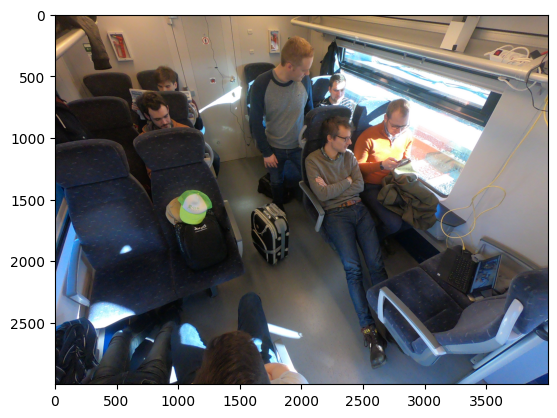

person detected


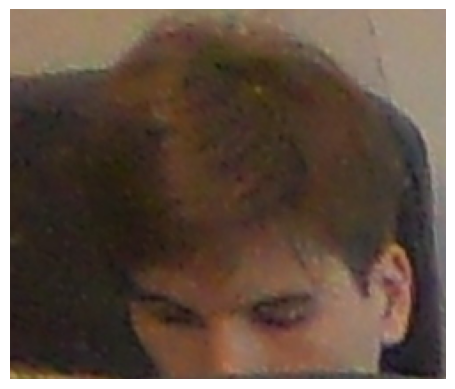

person detected


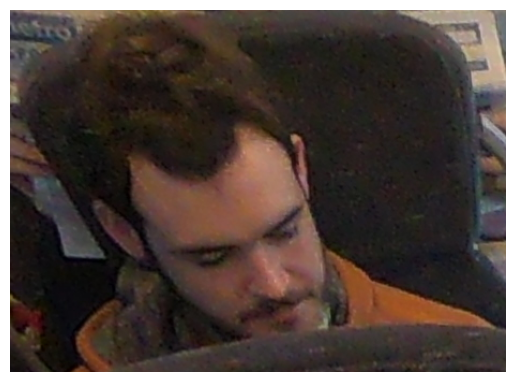

person detected


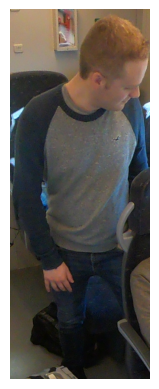

person detected


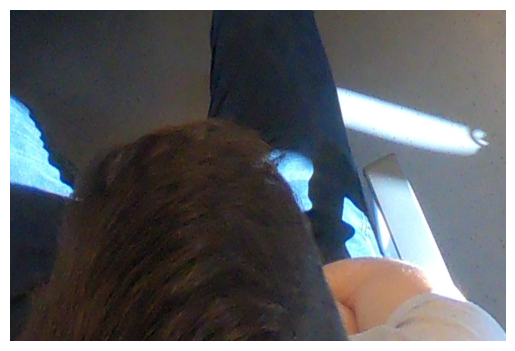

person detected


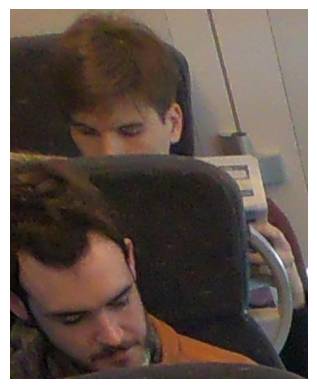

person detected


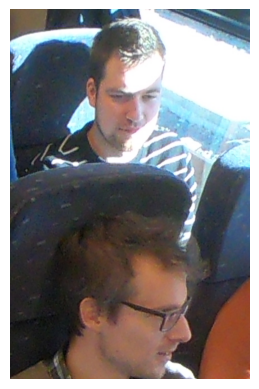

person detected


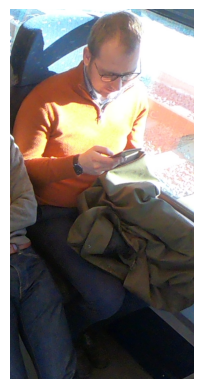

person detected


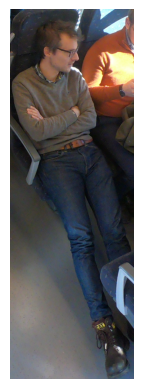

In [21]:
# Load DETR model
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Loop through input images
for image_path in glob.glob(os.path.join(input_dir, "*.JPG")):
    
    print(f"Analyzing image {image_path}")
    
    # Load image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    
    # Extract image features
    inputs = feature_extractor(image, return_tensors="pt")
    inputs.keys()
    
    outputs = model(**inputs)
    
    col = [[0.494, 0.184, 0.556], [0.484, 0.779, 0.088], [0.784, 0.745, 0.888],
              [0.492, 0.323, 0.732], [0.849, 0.484, 0.348], [0.929, 0.694, 0.125]]
    
    color = col * 100
    
    # keep bounding boxes with a 0.90 threshold
    probability = outputs.logits.softmax(-1)[0, :, :-1]
    threshold = probability.max(-1).values > 0.90

    # rescale 
    size = torch.tensor(image.size[::-1]).unsqueeze(0)
    output_after = feature_extractor.post_process(outputs, size)
    bounding_boxes = output_after[0]['boxes'][threshold]
    
    # plot result
    img_name = os.path.basename(image_path).split('.')[0] + ".JPG"
    img_path = os.path.join(output_dir, img_name)
    
    # plot_image(image, probability[threshold], bounding_boxes, img_path)
    
    boxnumber = len(bounding_boxes)

    label = image_boxes(image, probability[threshold], bounding_boxes)
    
    image = cv2.imread(image_path)
    
    for i in range(0, len(label)):
        if label[i] == "person": 
            print("person detected")
            X, Y, W, H = bounding_boxes[i].int()
            coordinates = image[Y:H, X:W]
            coordinates = cv2.cvtColor(coordinates, cv2.COLOR_BGR2RGB)
            plt.imshow(coordinates)
            img = f'{i}_{label[i]}.JPG'
            
            img_path = os.path.basename(image_path)+ img
            img_path_boxes = os.path.join(output_dir, img_path)
            plt.axis('off')
            plt.savefig(img_path_boxes)
            plt.show()

In [4]:
#function to plot DETR results
def image_boxes(image, probability, bounding_boxes):
    #rescale to avoid imagesize error
    #plt.figure(figsize=(16,10))
    #plt.imshow(image)
    
    #get current axis
    axis = plt.gca()
    
    #assigns label right above the box
    colors = col * 100
    
    label = []
    
    for p, (x_min, y_min, x_max, y_max), c in zip(probability, bounding_boxes.tolist(), colors):
        
        #add rectangle around tensor defined
        #axis.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   #fill=False, color=c, linewidth=3))
        
        cl = p.argmax()
        
        text = model.config.id2label[cl.item()]
        
        label.append(text)
        

    return label

In [ ]:
#function to plot DETR results
def plot_image(image, probability, bounding_boxes, save_path = None):
    #rescale to avoid imagesize error
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    
    #get current axis
    axis = plt.gca()
    
    #assigns label right above the box
    colors = col * 100

    for p, (x_min, y_min, x_max, y_max), c in zip(probability, bounding_boxes.tolist(), colors):
        
        #add rectangle around tensor defined
        axis.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        axis.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='red', alpha=0.3))
        
    #save_path
    if save_path is not None:
        plt.savefig(save_path)
        
    plt.show()